In [32]:
!pip3 install transformers

In [38]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import Trainer, TrainingArguments
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker

In [3]:
# veri setini import işlemi
import pandas as pd
dataframe = pd.read_csv('Suicide_Detection.csv')
dataframe.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
# Bu komutlar, veriyi sınıflarına göre ayırır ve her bir sınıfın boyutunu kontrol etmenizi sağlar.
suicide = dataframe[dataframe['class']=='suicide']
non_suicide = dataframe[dataframe['class']=='non-suicide']
suicide.shape, non_suicide.shape

((116037, 3), (116037, 3))

In [5]:
# Bu komutlar, veri setini dengeli hale getirmek için her iki sınıftan eşit sayıda örnek alır ve 
# yeni birleştirilmiş bir veri seti oluşturur.
suicide = suicide.head(60000)
non_suicide = non_suicide.head(60000)
dataframe = pd.concat([suicide,non_suicide])
dataframe.shape

(120000, 3)

In [6]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 0 to 120104
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  120000 non-null  int64 
 1   text        120000 non-null  object
 2   class       120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


In [7]:
# text ve class sütunlarında hiç eksik değer olmadığını gösterir. 
dataframe.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

### ön işleme

In [8]:
import re
!pip install autocorrect
from autocorrect import Speller
!pip install unidecode
import unidecode
!pip install contractions
import contractions
from string import punctuation

In [9]:
def text_cleaning(text):
    # Gönderilen metni küçük harfe dönüştürür
    text = text.lower()

    # Metinden tüm HTML etiketlerini temizler.
    html_pattern = r'<.*?>'
    text = re.sub(pattern=html_pattern, repl=' ', string=text)

    # Metinden tüm URL'leri temizler.
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(pattern=url_pattern, repl=' ', string=text)

    # Metinden tüm rakamları temizler.
    number_pattern = r'\d+'
    text = re.sub(pattern=number_pattern, repl=' ', string=text)

    # Unicode karakterlerini ASCII karakterlere dönüştürür.
    text = unidecode.unidecode(text)

    # Kısaltmaları genişleterek tam kelimeler haline getirir.
    text = contractions.fix(text)

    # Noktalama işaretlerini kaldırır.
    text = text.translate(str.maketrans('', '', punctuation))

    # Tek harfli kelimeleri kaldırır.
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    text = re.sub(pattern=single_char_pattern, repl=" ", string=text)

    # Ekstra boşlukları kaldırır.
    space_pattern = r'\s+'
    text = re.sub(pattern=space_pattern, repl=" ", string=text)

    return text

In [11]:
dataframe['text'] = dataframe['text'].apply(text_cleaning)
dataframe.head(100)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left my wi...,suicide
3,8,i need helpjust help me am crying so hard,suicide
4,9,i am so losthello my name is adam and have bee...,suicide
5,11,honetly idki do not know what am even doing he...,suicide
6,12,trigger warning excuse for self inflicted burn...,suicide
...,...,...,...
193,283,the cold sore did me inlet me prefix this with...,suicide
194,284,cannot shake the suicidal ideationive struggle...,suicide
195,285,can somebody talk to methere is shit in my lif...,suicide
196,287,police visit ukthrowaway due to obvious reason...,suicide


In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
lists = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HepsiBTC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HepsiBTC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
stopwords_list = ['i', 'am', 'is','are','this','that','then','those','have','has','it','can','could','the','had','was','were','been','them',
                  'what','whose','whom','who','do','did','does' 'yet', 'though', 'wherein', 'really', 'show', 'then', 'rather', 'same', 'con', 'call', 'is', 'twenty', 'side', 'go', 'namely',
                  'every', 'top', 'for', "'m", 'with', 'either', 'because', 'two', 'well', 'when', 'those', 'under', 'thin', 'amount', 'upon', 
                  'kg', 'the', "that'll", 'ca', 'even', 'very', 'into', 'by', '‘m', 'keep', 'although', 'done', 'bottom', 'detail', 'whatever', 
                  'from', 'formerly', 'these', 'enough', 'twelve', 'of', 'too', 'already', 'move', 'something', 'few', 'nothing', 'they', 'does',
                  'us', 'next', 'cry', 'but', 'eight', '‘s', 'however', 'four', "'ll", 'has', 'over', 'someone', 'afterwards', 'myself', 'have',
                  'would', 'anywhere', 'hereupon', 'using', 'everything', 'his', 'put', 'many', 'more', 'within', 'which', 'describe', 'thereby',
                  'nine', 'elsewhere', 'other', 'he', 'if', 'per', 'your', 's', 'be', 'than', 'now', 'sometime', 'herein', 'why', '‘d', 'whereas',
                  'behind', 'couldnt', 'de', "'re", 'least', 'latter', 'whereafter', 'part', 'after', 'front', 'interest', "you'd", 'whose', 'fire',
                  'sincere', 'down', 'to', 'whence', 'ours', "'s", 'all', 'noone', 'just', 'anyhow', 'ie', 'having', 'her', 'been', 'get', 'former', 
                  'throughout', 'above', '’d', 'cannot', 'almost', 'do', 'quite', 'seem', 'give', 'first', 'several', 'also', 'seems', 'became', '’m',
                  'sixty', 'anyway', '‘re', 'on', "you're", 'onto', 'co', 'third', 'fifty', 'had', 'seemed', '’s', 'yourselves', 'until', 'an', 'mine',
                  'across', 'sometimes', 'hereby', 'eleven', 'might', 'mostly', 'un', 'i', "'d", 'itself', 'most', 'beforehand', 'five', 'beyond',
                  'herself', "you've", 'unless', 'regarding', 'there', 'doesn', 'while', 'whoever', "should've", 'whereupon', 'name', 'further', 'o', 
                  'nobody', 'whereby', 'others', 'between', 'thus', 'any', "you'll", 'found', 'amongst', 'hers', 'wherever', 'ltd', 'still', 'somehow',
                  'often', 'km', 'becoming', 'six', 'can', "'ve", 'make', 'hence', 'around', 'both', 'our', 'along', 'latterly', 'please', 'via', 'whole',
                  'system', 've', 'd', 'you', 'themselves', 'here', 'used', 'in', 'forty', 'each', 'find', 'during', 'ain', 'ten', 'him', 'nevertheless',
                  "she's", 'me', 'them', 'ma', 'meanwhile', 'and', 'y', 'did', 'fifteen', 'serious', '’re', "it's", '’ll', 'that', 'alone', 'together', 
                  'where', 'hereafter', 'once', 'himself', 'could', 'made', 'among', 'whom', 'cant', 'doing', 'again', 'therefore', 'beside', 'hundred',
                  'three', 'etc', 'moreover', 'various', 'may', 'since', 'always', 'seeming', 'toward', 'are', 'll', 'everywhere', 'a', 'empty', 'yours',
                  'theirs', 'back', 'else', 'own', 'as', 'somewhere', 'bill', '‘ll', 're', 'through', 'last', 'nowhere', 'what', 'take', 'computer',
                  'yourself', 'eg', 'perhaps', 'thereupon', 'ourselves', 'against', 'inc', 'she', 'whether', 'their', 'm', 'such', 'thick', 'anything',
                  '’ve', 'neither', 'none', 'amoungst', 'one', 'were', 'thru', 'am', 'about', 'without', 'up', 'otherwise', 'except', 'who', 'due',
                  'thereafter', 'ever', 'much', 'out', 'how', 'whenever', 'before', 'it', 'some', 'being', 'mill', 'or', 'its', 'will', 'become',
                  'besides', 'say', 'therein', 'another', 'see', 'anyone', 'becomes', 'never', 'towards', 'everyone', 'below', 'full', 'my', 'only', 
                  'fill', 'we', 'should', 'thence', 'indeed', 'this', 'was', 'less', 'so', 't', 'at', 'must', 'whither', 'off'
]

In [14]:
def remove_stopwords(text):
    token = word_tokenize(text)
    token_without_stopwords = []
    for words in token:
        if words not in stopwords_list:
            token_without_stopwords.append(words)
    text = " ".join(token_without_stopwords)
    return text

In [15]:
dataframe['text'] = dataframe['text'].apply(remove_stopwords)
dataframe.head(100)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left wife ...,suicide
3,8,need helpjust help crying hard,suicide
4,9,losthello adam struggling years afraid past ye...,suicide
5,11,honetly idki not know feel like feel unbearabl...,suicide
6,12,trigger warning excuse self inflicted burnsi k...,suicide
...,...,...,...
193,283,cold sore inlet prefix saying cold sores not b...,suicide
194,284,not shake suicidal ideationive struggled depre...,suicide
195,285,somebody talk methere shit life need talk mayb...,suicide
196,287,police visit ukthrowaway obvious reasons night...,suicide


In [17]:
dataframe['class']=pd.factorize(dataframe['class'])[0]

In [19]:
dataframe.head(10)

,Unnamed: 0,text,class
0,2,ex wife threatening suiciderecently left wife ...,0
3,8,need helpjust help crying hard,0
4,9,losthello adam struggling years afraid past ye...,0
5,11,honetly idki not know feel like feel unbearabl...,0
6,12,trigger warning excuse self inflicted burnsi k...,0
7,13,ends tonighti not anymore quit,0
9,18,life years oldhello year old balding male hair...,0
10,19,took rest sleeping pills painkillersi not wait...,0
11,20,imagine getting old neitherwrinkles weight gai...,0
12,21,think getting hit train painfulguns hard come ...,0


### Verileri eğitim ve test kümelerine ayırma

In [20]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(dataframe, test_size=0.33, random_state=42)

In [21]:
train=train[["text","class"]]
test=test[["text","class"]]

In [22]:
train.head()

,text,class
2102,need someonenot great place right,0
46133,not depressed suicidal thoughtsim yrs old reme...,0
9385,hard days waitingthe days extremely hard thoug...,0
77370,look forward toedit appreciate mail gotten not...,0
24475,cool want dispensary alice wonderland themed s...,1


## BERT

In [27]:
!pip install simpletransformers

In [28]:
from simpletransformers.classification import ClassificationModel

In [29]:
# bert için text sütunu string , class sütunu int olması gerekiyor
train["text"]=train["text"].apply(lambda r: str(r))
train["class"]=train["class"].astype(int)

In [30]:
#Model ayarlarının yapılması
model=ClassificationModel('bert',
                          'bert-base-uncased',
                          num_labels=2,
                          use_cuda=False,
                         args={
                             'reprocess_input_data':True,
                             'overwrite_output_dir':True,
                             'num_train_epochs':3,
                             "train_batch_size":64,
                             "fp16":False,
                             "output_dir":"bert_model"})

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
#Model kurulumu
model.train_model(train)

C:\Users\HepsiBTC\anaconda3\Lib\site-packages\simpletransformers\classification\classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/160 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/1257 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/1257 [00:00<?, ?it/s]

Running Epoch 3 of 3:   0%|          | 0/1257 [00:00<?, ?it/s]

(3771, 0.06598314603999979)

In [32]:
result, model_outputs,wrong_predictions=model.eval_model(test)

C:\Users\HepsiBTC\anaconda3\Lib\site-packages\simpletransformers\classification\classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/79 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/396 [00:00<?, ?it/s]

In [33]:
predictions=model_outputs.argmax(axis=1)

In [34]:
actuals = test['class'].values

In [52]:
predictions[:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

In [36]:
actuals[:10]

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy Score Sonucu:",accuracy_score(actuals,predictions))
print("Precision Score Sonucu:",precision_score(actuals,predictions))
print("F1 Score Sonucu:",f1_score(actuals,predictions))
print("Recall Score Sonucu:",recall_score(actuals,predictions))

Accuracy Score Sonucu: 0.9764141414141414
Precision Score Sonucu: 0.9735511277435016
F1 Score Sonucu: 0.9763160563951718
Recall Score Sonucu: 0.9790967348184315


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

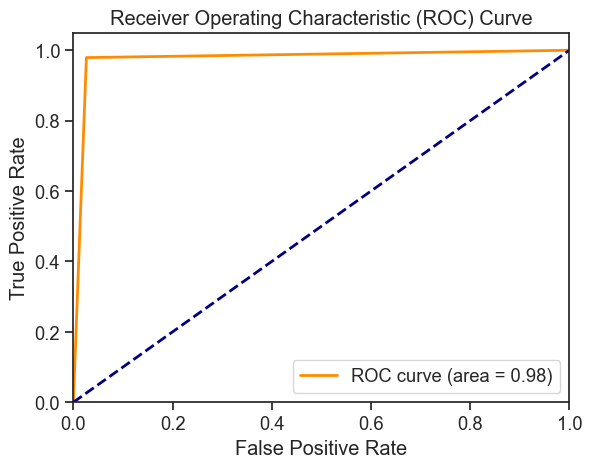

In [56]:
# ROC eğrisi için etiketleri binarize etme
y_test_binarized = label_binarize(test["class"], classes=[0, 1])

# FPR, TPR ve eşikleri hesaplama
fpr, tpr, _ = roc_curve(y_test_binarized, predictions)
roc_auc = auc(fpr, tpr)

# ROC eğrisini çizme
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()